In [1]:
# This line solves some minor problems when you do not have propery set the PYTHONPATH
exec(compile(open("fix_paths.py", "rb").read(), "fix_paths.py", 'exec'))

## Load data example

In [2]:
from common import dataset_loaders
original_labels = dataset_loaders.groundlabels_dataframe()

map_category = {'A':'A', 'B':'B', 'C':'C', 'D':'D', 'E':'E', 'F':'F', 'G':'G', 'H':'H', 'I':'I'}
glabels = dataset_loaders.map_labels(original_labels, map_category)

# Plot data example

In [3]:
from common import plot_utils
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
casename = dataset_loaders.get_casenames()[0]
img = dataset_loaders.load_image(casename)
labels = glabels[glabels['image'] == casename]
plot_utils.draw(img, labels)

In [ ]:
import settings as st


In [ ]:
start_case = 17
for i in range(start_case, len(dataset_loaders.get_casenames())):
    try:
        casename = dataset_loaders.get_casenames()[i]
        labels = glabels[glabels['image'] == casename]
        img = dataset_loaders.load_image(casename)
        ann_fps = np.load(st.DATAMODEL_PATH+'/patches_single_size_fps/annotations/'+[x for x in os.listdir(st.DATAMODEL_PATH+'/patches_single_size_fps/annotations') if casename in x][0])['preds']
        ann_normal = np.load(st.DATAMODEL_PATH+'/patches_single_size/annotations/' + [x for x in os.listdir(st.DATAMODEL_PATH+'/patches_single_size/annotations') if casename in x][0])['preds']
        print('loaded case %d' % i)
        break
    except:
        continue


In [ ]:
window_size = 110
scan_window = 10
pl_wind = 40
def reconstruct_original(img, preds):
    rec_im = np.zeros(img.shape[:2])
    for i in range(int(window_size/2),img.shape[0]-int(window_size/2),scan_window):
        for j in range(int(window_size/2),img.shape[1]-int(window_size/2),scan_window):
            value = 1-preds[int(int(i-window_size/2) / scan_window), int(int(j-window_size/2) / scan_window)][-1]
            rec_im[i-int(pl_wind/2):i+int(pl_wind/2),j-int(pl_wind/2):j+int(pl_wind/2)] += value
    return rec_im

rec_fps = reconstruct_original(img, ann_fps)
rec = reconstruct_original(img, ann_normal)

In [ ]:
figure()
plot_utils.draw(img, labels)
plot_fps = np.copy(rec_fps)
plot_fps[plot_fps<1] = np.nan
imshow(plot_fps, alpha = 1, cmap = cm.Reds)

In [ ]:
casename = case

from skimage.feature import blob_dog, blob_log, blob_doh
import pandas as pd



def detect_blobs(preds):
    blobs = blob_doh(np.nan_to_num(plot_fps), max_sigma=30, threshold=.05)
    if blobs.shape[0] > 0:
        #detected = pd.DataFrame(blobs_doh[blobs_doh[:,2] > 0], columns = ['x','y','r'])
        detected = pd.DataFrame(blobs, columns = ['x','y','r'])
    else:
        detected = pd.DataFrame(columns = ['x','y','r'])        
    return detected

img = dataset_loaders.load_image(casename)
labels = glabels[glabels['image'] == casename]
plot_utils.draw(img, labels)

figure()
ax = subplot(111)
imshow(img)
imshow(plot_fps, cmap = cm.Greens, alpha = 0.4)
blobs = blob_doh(np.nan_to_num(plot_fps), max_sigma=30, threshold=.05)
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='r', linewidth=2, fill=False)
    ax.add_patch(c)

In [ ]:
#figure()
#ax = subplot(111)
#imshow(img)
#imshow(plot_fps, cmap = cm.Greens, alpha = 0.4)
#blobs = blob_doh(np.nan_to_num(plot_fps), max_sigma=30, threshold=.05)
#print(len(blobs))
#for blob in blobs:
#    y, x, r = blob
#    c = plt.Circle((x, y), r, color='r', linewidth=2, fill=False)
#    ax.add_patch(c)

In [ ]:
blobs

In [ ]:

from skimage.feature import blob_dog, blob_log, blob_doh
import pandas as pd
import settings as st
import numpy as np 

test = False        

window_size = 110
scan_window = 10
pl_wind = 40


def find_matches(casename, labels, detected, accepted_radius = 50):
    ## It take two dataframes:
    ### Labels: 'id', 'image', 'class', 'x', 'y'
    ### Detected: 'x', 'y', 'r'
    
    dfres = pd.DataFrame(columns = ['id','xref','yref','classref','xdet','ydet','rdet','pointtype'])

    ## TPositives
    for i_row in detected.index.values:
        if labels is None:
            # This is, for sure a FP
            xdet, ydet, radiusdet = detected.ix[i_row].x, detected.ix[i_row].y, detected.ix[i_row].r
            dfres.loc[dfres.shape[0]] = [casename, None, None, None, xdet, ydet, radiusdet,'Unknown']
        else:
            xdet, ydet, radiusdet = detected.ix[i_row].x, detected.ix[i_row].y, detected.ix[i_row].r
            dist_radius = ((labels[['x','y']]-detected.ix[i_row][['x','y']])**2).sum(axis=1).apply(np.sqrt)
            min_dist = dist_radius.min()
            if min_dist < accepted_radius:
                # This is a match. TP
                match_case = labels.ix[dist_radius.argmin()]
                xref, yref, classref = match_case.x, match_case.y, match_case['class']
                dfres.loc[dfres.shape[0]] = [casename, xref, yref, classref, xdet, ydet, radiusdet,'TP']
            else:
                # This case is a FP
                dfres.loc[dfres.shape[0]] = [casename, None, None, None, xdet, ydet, radiusdet,'FP']
    # If a point has not been matched to any point dref, it means it is a FN
    if labels is not None:
        for i_row in labels.index.values:
            if labels.ix[i_row].x not in dfres.xref.values:
                dfres.loc[dfres.shape[0]] = [casename, labels.ix[i_row].x, labels.ix[i_row].y, labels.ix[i_row]['class'],None, None, None, 'FN']
    return dfres

def reconstruct_original(img, preds):
    rec_im = np.zeros(img.shape[:2])
    for i in range(int(window_size/2),img.shape[0]-int(window_size/2),scan_window):
        for j in range(int(window_size/2),img.shape[1]-int(window_size/2),scan_window):
            value = 1-preds[int(int(i-window_size/2) / scan_window), int(int(j-window_size/2) / scan_window)][-1]
            rec_im[i-int(pl_wind/2):i+int(pl_wind/2),j-int(pl_wind/2):j+int(pl_wind/2)] += value
    return rec_im

def detect_blobs(preds):
    blobs = blob_doh(np.nan_to_num(preds), max_sigma=30, threshold=.05)
    if blobs.shape[0] > 0:
        #detected = pd.DataFrame(blobs_doh[blobs_doh[:,2] > 0], columns = ['x','y','r'])
        detected = pd.DataFrame(blobs, columns = ['x','y','r'])
    else:
        detected = pd.DataFrame(columns = ['x','y','r'])        
    return detected

def get_predictions(casename, return_debug_data = False):
    img = dataset_loaders.load_image(casename)
    ann_fps = np.load(st.DATAMODEL_PATH+'/patches_single_size_fps/annotations/'+[x for x in os.listdir(st.DATAMODEL_PATH+'/patches_single_size_fps/annotations') if casename in x][0])['preds']

    rec_fps = reconstruct_original(img, ann_fps)
    plot_fps = np.copy(rec_fps)
    plot_fps[plot_fps<1] = np.nan
    blobs = detect_blobs(np.nan_to_num(plot_fps))
    if return_debug_data:
        return blobs, img, plot_fps
    else:
        return blobs
    
def get_next_case(start_case):
    casename = None
    for i in range(start_case, len(dataset_loaders.get_casenames())):
        try:
            casename = dataset_loaders.get_casenames()[i]
            labels = glabels[glabels['image'] == casename]
            img = dataset_loaders.load_image(casename)
            ann_fps = np.load(st.DATAMODEL_PATH+'/patches_single_size_fps/annotations/'+[x for x in os.listdir(st.DATAMODEL_PATH+'/patches_single_size_fps/annotations') if casename in x][0])['preds']
            print('loaded case %d' % i)
            break
        except:
            continue
    return casename, i

def plot_blobs(casename):    
    blobs, img, plot_fps = get_predictions(casename, return_debug_data = True)
    labels = glabels[glabels['image'] == casename]
    figure()
    ax = subplot(111)
    imshow(img)
    plot(labels.y.values, labels.x.values, 'ob')
    imshow(plot_fps, cmap = cm.Reds, alpha = 0.25)
    for blob in blobs.values:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='r', linewidth=2, fill=False)
        ax.add_patch(c)

def define_labels(casename, blobs, is_test):
    if is_test == True:
        labels = None
    else:
        labels = glabels[glabels['image'] == casename]
    return find_matches(casename, labels, blobs, accepted_radius = 20)

res = []
next_i = -1
for i_case, casename in enumerate(dataset_loaders.get_casenames()):
    print(i_case, casename)
    #casename, next_i = get_next_case(next_i+1)
    #plot_blobs(casename)
    out = define_labels(casename, get_predictions(casename), is_test = False)
    res.append(out)

csv = pd.concat(res)
csv.to_csv('train_predicted_positions_2.csv', index = False)
csv.groupby('pointtype')['id'].count()

#import pandas as pd
#csv = pd.read_csv('train_predicted_positions.csv')
##csv.groupby('pointtype')['id'].count()
#csv.groupby(['id','pointtype'])['id'].count().unstack('pointtype').sort_values(by='FN', ascending = False)

0 TQ3477_6_7
1 TQ2483_9_0
2 TQ2379_5_7
3 TQ2483_7_5
4 TQ2684_3_9
5 TQ3080_1_2
6 TQ2379_7_1
7 TQ2483_2_6
8 TQ2483_3_8
9 TQ3080_8_8
10 TQ3779_2_4
11 TQ2483_3_4
12 TQ3477_4_7
13 TQ2483_7_1
14 TQ2379_3_9
15 TQ3779_8_1
16 TQ2684_2_8
17 TQ2483_9_7
18 TQ2684_7_4
19 TQ3779_2_6
20 TQ2684_6_5
21 TQ2684_8_3
22 TQ2684_1_9
23 TQ3080_0_4
24 TQ2684_4_1
25 TQ3477_3_5
26 TQ2684_7_8
27 TQ2379_7_0
28 TQ3477_7_3
29 TQ3477_7_9
30 TQ3477_8_9
31 TQ3080_6_6
32 TQ3080_5_6
33 TQ3779_4_9
34 TQ3477_8_8
35 TQ3779_7_9
36 TQ2483_5_2
37 TQ2483_2_3
38 TQ3477_2_7
39 TQ3779_9_5
40 TQ2483_3_2
41 TQ3477_0_0
42 TQ3779_2_8
43 TQ3080_3_8
44 TQ2684_8_6
45 TQ2379_0_1
46 TQ2379_4_2
47 TQ3779_4_7
48 TQ2684_6_4
49 TQ3080_0_7
50 TQ3477_8_0
51 TQ3477_0_2
52 TQ3779_0_2
53 TQ3080_1_4
54 TQ3477_7_6
55 TQ2684_6_0
56 TQ2483_1_9
57 TQ2684_4_2
58 TQ2483_6_6
59 TQ2379_3_4
60 TQ3779_6_0
61 TQ3080_7_9
62 TQ3477_0_1
63 TQ2379_7_4
64 TQ3779_7_6
65 TQ2483_2_1
66 TQ2379_6_5
67 TQ3080_6_9
68 TQ3477_1_1
69 TQ2379_1_8
70 TQ3477_5_6
71 TQ2684_9_8
72

In [ ]:
aux = csv.groupby(['id','pointtype'])['id'].count().unstack('pointtype')
aux.sort_values('FN', ascending = False).head()

Populating the interactive namespace from numpy and matplotlib


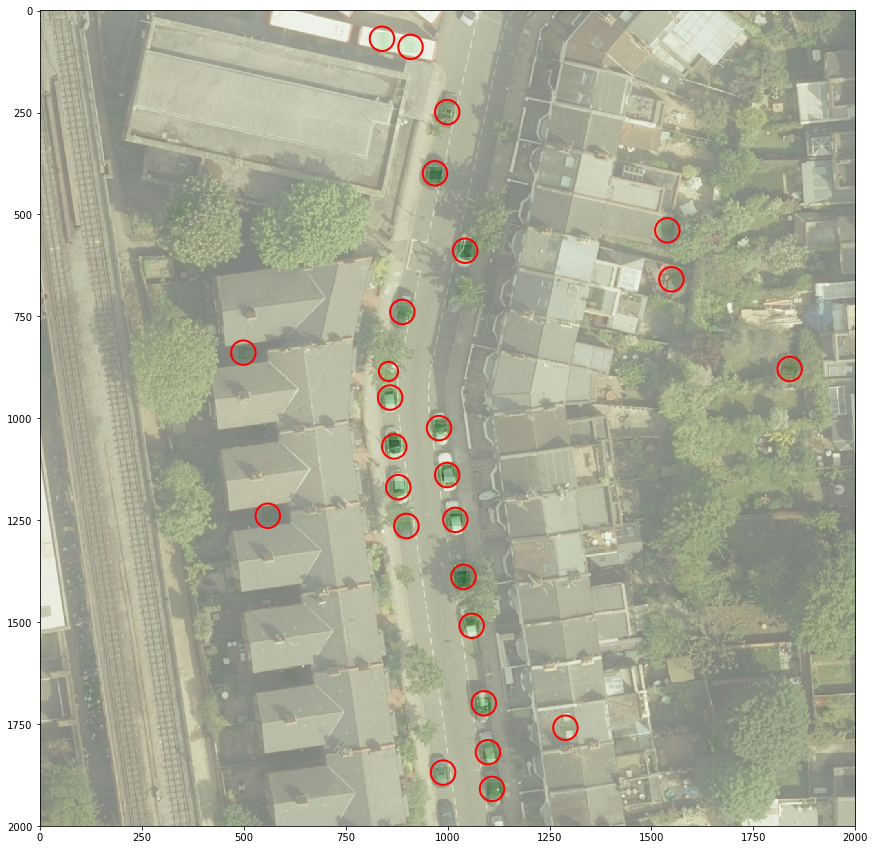

In [17]:
casename = 'TQ2379_2_5'

import settings as st
from common import plot_utils
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)
from skimage.feature import blob_dog, blob_log, blob_doh
import pandas as pd

window_size = 110
scan_window = 10
pl_wind = 40

def reconstruct_original(img, preds):
    rec_im = np.zeros(img.shape[:2])
    for i in range(int(window_size/2),img.shape[0]-int(window_size/2),scan_window):
        for j in range(int(window_size/2),img.shape[1]-int(window_size/2),scan_window):
            value = 1-preds[int(int(i-window_size/2) / scan_window), int(int(j-window_size/2) / scan_window)][-1]
            rec_im[i-int(pl_wind/2):i+int(pl_wind/2),j-int(pl_wind/2):j+int(pl_wind/2)] += value
    return rec_im

def detect_blobs(preds):
    blobs = blob_doh(np.nan_to_num(plot_fps), max_sigma=30, threshold=.05)
    if blobs.shape[0] > 0:
        #detected = pd.DataFrame(blobs_doh[blobs_doh[:,2] > 0], columns = ['x','y','r'])
        detected = pd.DataFrame(blobs, columns = ['x','y','r'])
    else:
        detected = pd.DataFrame(columns = ['x','y','r'])        
    return detected

img = dataset_loaders.load_image(casename)
ann_fps = np.load(st.DATAMODEL_PATH+'/patches_single_size_fps/annotations/'+[x for x in os.listdir(st.DATAMODEL_PATH+'/patches_single_size_fps/annotations') if casename in x][0])['preds']
plot_fps = reconstruct_original(img, ann_fps)

labels = glabels[glabels['image'] == casename]
#plot_utils.draw(img, labels)

figure()
ax = subplot(111)
imshow(img)
imshow(plot_fps, cmap = cm.Greens, alpha = 0.4)
blobs = blob_doh(np.nan_to_num(plot_fps), max_sigma=30, threshold=.05)
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='r', linewidth=2, fill=False)
    ax.add_patch(c)